# Gene Expression Analysis Pipeline
This notebook processes gene expression data to identify the top genes that differ most consistently from control means across multiple studies. It then visualizes these differences using PCA.

## ChatGPT prompt
The code was mostly generated by ChatGPT's Data Analyst model. Below is the prompt that I started with:

I have multiple studies with gene expression data. Each Study has one or more families/species under study, indicated by the column 'BREED'. Some samples (indicated by the column 'Experiment'), are Controls, and others are treatments, indicated by the Boolean-valued column 'Control'.

For each sample, use expression counts per million, and filter out genes where CPM < 10 across all samples.

Exclude the Study named Johnson et al. 2020.

Within each BREED within each Study, for each gene_id, find the mean and variance of the expression values of the Control samples. So for each BREED, you'll have mean and variance values for the Control samples. Let's call this control_stats_per_breed.
And then for each non-Control sample within each BREED within each Study, for each gene_id, subtract the gene count from the control_stats_per_breed mean to arrive at difference_from_control_mean for that sample and gene_id.

I now want to take the top 5000 genes that differ most consistently (with the constraint of statistical significance considering variance) including sign (no absolute values) from their respective control_stats_per_breed means across all Studies. Use a variable for 5000 so that it can be easily changed.

Report on how you evaluate that statistical significance and give me a sense of the quality of the consistency across Studies for these 5000 genes.

Perform PCA on these gene-level differences to visualize patterns across studies and families.
I will provide a gene expression matrix and metadata. Please help me process the data in a memory-efficient way, considering that the dataset may be large.

## Steps:
1. Load and preprocess data
2. Compute control statistics
3. Compute differences from control means
4. Perform statistical tests and select top genes
5. Perform PCA and visualize results

## Step 1: Load Data
We first load the metadata and gene expression matrix.

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import ttest_1samp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load metadata and gene expression data
working_dir = "~/git/Cvirg_Pmarinus_RNAseq/data/"
# === 1️⃣ Load Expression Data (TSV) ===
expression_file = os.path.join(working_dir, "rnaseq_gene_counts", "merged_gene_counts.tsv")
gene_counts = pd.read_csv(expression_file, sep="\t", index_col=0)

# Load the metadata file
metadata_file_path = os.path.join(working_dir, "augmented_metadata.csv")
metadata = pd.read_csv(metadata_file_path)



## Step 2: Preprocess Data
- Compute Counts Per Million (CPM)
- Remove genes with CPM < 10
- Exclude 'Johnson et al. 2020' study

In [2]:
# Compute Counts Per Million (CPM)
library_sizes = gene_counts.sum(axis=0)
cpm = (gene_counts / library_sizes) * 1e6

# Filter out genes with CPM < 10 across all samples
filtered_genes = cpm[(cpm >= 10).any(axis=1)]

# Exclude 'Johnson et al. 2020'
excluded_study = 'Johnson et al. 2020'
samples_to_exclude = metadata[metadata['Study'] == excluded_study]['Experiment'].tolist()

filtered_metadata = metadata[~metadata['Experiment'].isin(samples_to_exclude)]
filtered_gene_counts = filtered_genes.drop(columns=samples_to_exclude, errors='ignore')

## Step 3: Compute Control Statistics
For each `BREED` within each `Study`, compute the mean and variance of control samples.

In [3]:
sample_to_breed_study = filtered_metadata.set_index('Experiment')[['Study', 'BREED', 'control']]
control_samples = sample_to_breed_study[sample_to_breed_study['control'] == 1].index

# Compute mean and variance for control samples
control_stats_per_breed = (
    filtered_gene_counts[control_samples]
    .T.join(sample_to_breed_study, how='left')
    .groupby(['Study', 'BREED'])
    .agg(['mean', 'var'])
)
control_stats_per_breed = control_stats_per_breed.swaplevel(axis=1)

## Step 4: Compute Differences from Control Means
For each non-control sample, subtract the control mean for its corresponding `BREED`.

In [4]:
differences = []
non_control_samples = sample_to_breed_study[sample_to_breed_study['control'] == 0].index

for (study, breed), group in sample_to_breed_study.loc[non_control_samples].groupby(['Study', 'BREED']):
    if (study, breed) in control_stats_per_breed.index:
        control_means = control_stats_per_breed.loc[(study, breed)]['mean']
        samples = group.index
        subset = filtered_gene_counts.loc[:, samples]
        difference_from_control_mean = subset.sub(control_means, axis=0)
        differences.append(difference_from_control_mean)

differences_df = pd.concat(differences, axis=1)

## Step 5: Perform Statistical Tests
We standardize the differences using control variance and perform one-sample t-tests.

In [14]:
# Compute standardized effect size
control_variance = control_stats_per_breed.xs('var', level=0, axis=1)
control_std = np.sqrt(control_variance.replace(0, np.nan))

aligned_control_std = control_std.T.reindex(index=differences_df.index, columns=differences_df.columns)
aligned_control_std = aligned_control_std.replace({0: np.nan}).fillna(1e-6)

standardized_differences = differences_df.div(aligned_control_std)

# Perform one-sample t-tests
t_stats, p_values = [], []
min_samples_required = 5
valid_genes = standardized_differences.dropna(thresh=min_samples_required)

for gene in valid_genes.index:
    values = valid_genes.loc[gene].dropna().values
    if len(values) > 1:
        t_stat, p_val = ttest_1samp(values, 0, nan_policy='omit')
    else:
        t_stat, p_val = np.nan, np.nan
    t_stats.append(t_stat)
    p_values.append(p_val)

stats_df = pd.DataFrame({'t_stat': t_stats, 'p_value': p_values}, index=valid_genes.index)
stats_df['adjusted_p_value'] = stats_df['p_value'] * len(stats_df) / (stats_df['p_value'].rank(method='min'))

# Select top genes
TOP_N_GENES = 500
top_genes = stats_df.nsmallest(TOP_N_GENES, 'adjusted_p_value').index

## Step 6: PCA and Visualization
Perform PCA on the top N genes to visualize differences across samples.

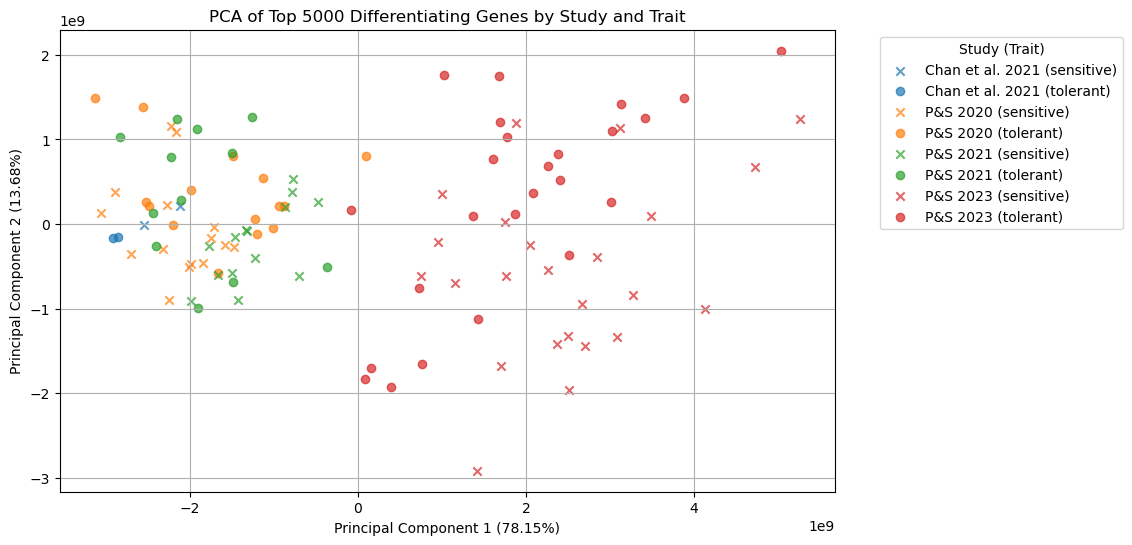

In [ ]:
top_gene_differences = standardized_differences.loc[top_genes].dropna(axis=1, how='all')

# Define markers for traits
trait_markers = {"sensitive": "x", "tolerant": "o"}

# Perform PCA on the top 5000 genes
pca = PCA(n_components=2)
pca_result = pca.fit_transform(top_gene_differences.T)

# Compute explained variance for axis labels
explained_variance = pca.explained_variance_ratio_ * 100

# Create DataFrame for visualization
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=top_gene_differences.columns)
pca_df = pca_df.join(filtered_metadata.set_index("Experiment"))

# Generate a color palette for studies
import seaborn as sns
study_palette = sns.color_palette("tab10", n_colors=pca_df["Study"].nunique())
study_colors = dict(zip(pca_df["Study"].unique(), study_palette))

# Plot PCA colored by Study, using different markers for traits
plt.figure(figsize=(10, 6))
for (study, trait), subset in pca_df.groupby(["Study", "Trait"]):
    marker = trait_markers.get(trait, "o")  # Default to 'o' if trait is missing
    plt.scatter(subset["PC1"], subset["PC2"],
                label=f"{study} ({trait})",
                color=study_colors[study],  # Assign the same color within each Study
                alpha=0.7, marker=marker)

# Update axis labels to include variance explained
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.2f}%)")
plt.title(f"PCA of Top {TOP_N_GENES} Differentiating Genes by Study and Trait")

# Adjust legend for readability
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Study (Trait)")
plt.grid(True)
plt.show()

